# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
# dataset = get_dataset("/home/workspace/data/waymo/training_and_validation/*.tfrecord")
filepath = "/home/workspace/data/train/"
dataset = get_dataset(f"{filepath}*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


In [3]:
### create batch for display
# batch size
num_images = 15
# number of rows in plot
num_rows = 3

batch = dataset.shuffle(86, reshuffle_each_iteration=True).take(num_images)

### initial exploration of TFrecords

In [4]:
# display dataset specs
dataset.element_spec

{'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 'source_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'key': TensorSpec(shape=(), dtype=tf.string, name=None),
 'filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'groundtruth_image_confidences': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_verified_neg_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_not_exhaustive_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_boxes': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None),
 'groundtruth_area': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_difficult': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_group_of': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_weights': TensorSpec(shape=(None,), dtype=tf.float32, name=Non

In [5]:
# image size 640x640
for record in batch:
    print(record["original_image_spatial_shape"].numpy())

[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]


In [6]:
# bboxes in format [0...1] - rescale to image size
for record in batch:
    print(record["groundtruth_boxes"].numpy())

[[0.5383318  0.47994262 0.55116093 0.48717958]
 [0.5390719  0.49392313 0.5642368  0.52254206]
 [0.5388252  0.39260554 0.5526413  0.40872425]
 [0.54869384 0.08503439 0.56053615 0.10904796]
 [0.5437595  0.58339834 0.5634967  0.6251754 ]
 [0.5403055  0.83126456 0.5600427  0.8385015 ]
 [0.5499274  0.00641459 0.56719744 0.04621791]
 [0.5454865  0.27171528 0.5637434  0.29276827]
 [0.54820037 0.07023149 0.56695074 0.10937691]
 [0.53537136 0.53380203 0.56300384 0.5780475 ]
 [0.5472135  0.2245105  0.5600427  0.25576106]
 [0.54820037 0.22154993 0.564977   0.2455635 ]
 [0.53561795 0.52879214 0.5390719  0.53570014]
 [0.53759164 0.30345926 0.5637434  0.3445784 ]]
[[0.5533814  0.400007   0.56769085 0.4026386 ]
 [0.5491053  0.4076274  0.56045413 0.42177227]
 [0.54968065 0.68307114 0.56941783 0.7103743 ]
 [0.56275654 0.1291141  0.6500936  0.15181187]
 [0.5521478  0.6128397  0.59951705 0.6641564 ]
 [0.5847142  0.11135063 0.6458995  0.12878515]
 [0.56127626 0.7286312  0.5706514  0.73784184]
 [0.54968065

## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [7]:
def display_images(batch):
    # color mapping of classes
    colormap = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}
    # matching legend lines
    legend_lines = [Line2D([0], [0], color=colormap[1], lw=1, label="vehicles"), 
                    Line2D([0], [0], color=colormap[2], lw=1, label="pedestrians"), 
                    Line2D([0], [0], color=colormap[4], lw=1, label="bicycles")]
    # define rows/cols in figure
    if num_images % num_rows == 0:
        num_cols = num_images // num_rows
    else:
        num_cols = num_images % num_rows + 1

    # set up figure
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    fig.suptitle('Observations - Ground Truth Data', fontsize=14)

    ### for each tfrecord in batch...
    for idx, record in enumerate(batch):

        # ...get specs
        img = record["image"].numpy()
        img_shape = record["original_image_spatial_shape"].numpy()
        filename = record["filename"]
        gt_bboxes = record["groundtruth_boxes"].numpy()
        gt_classes = record["groundtruth_classes"].numpy()

        # ...get image and put in background
        curr_row = idx % num_rows
        curr_col = idx % num_cols
        axs[curr_row, curr_col].imshow(img)

        # ...add bounding boxes to the foregound
        for box, cl in zip(gt_bboxes, gt_classes):
            # get box coordinates
            y1, x1, y2, x2 = box
            # rescale to image size
            x1, x2 = img_shape[0]*x1, img_shape[0]*x2
            y1, y2 = img_shape[1]*y1, img_shape[1]*y2
            # define rectangle and color with colormap
            rec = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, facecolor='none', edgecolor=colormap[cl])
            # add rectangle to plot
            axs[curr_row, curr_col].add_patch(rec)

    # add legend and adjust layout
    axs[num_rows-1,0].legend(handles=legend_lines, loc='center', bbox_to_anchor=(0,-0.2))
    plt.tight_layout()

    # display
    plt.show()

    # save figure to png
    fig.savefig('results/data_exploratory_analysis.png')
    pass

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

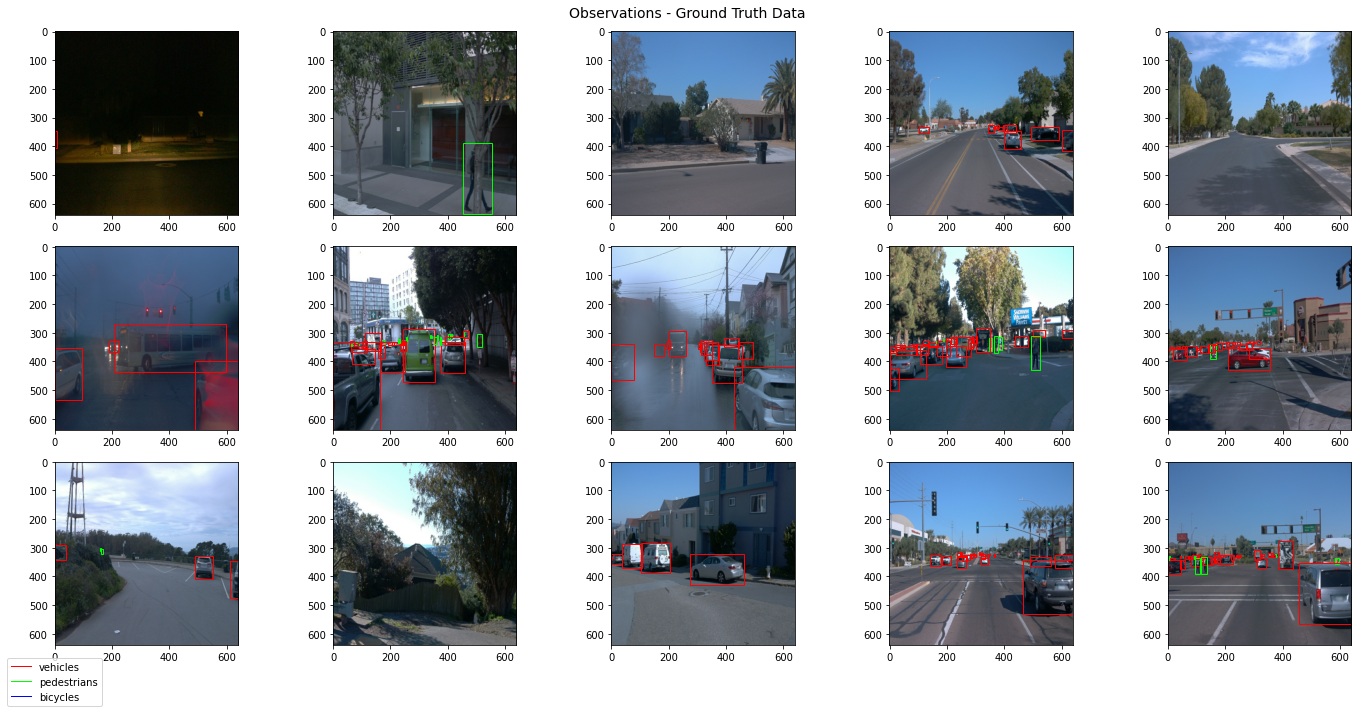

In [8]:
# Display 10 random images in training dataset
display_images(batch)

### Observations
At first glance, it becomes obvious that the class distribution in our dataset is skewed. There are a lot of vehicles, as opposed to lesser pedestrians and almost no bicycles. Model performance should be monitored closely especially for the minority classes. In order to avoid poor performance of the object detection for the minority class, one could adopt multitude of strategies such as resampling, adapting the performance metrics etc. Some general proposals can be found [here]().

The light conditions vary across the dataset, with sunny conditions leading to brighter images as well as rainy/foggy conditions, leading to reflections and blurs in the images. Also, there are recordings of night drives. Image distortions can be observed as well.

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [9]:
for cl in dataset.take(86):
    print(np.unique(cl['groundtruth_classes'].numpy(), return_counts=True))

(array([1]), array([6]))
(array([1]), array([10]))
(array([1, 2]), array([29,  2]))
(array([1, 2]), array([23,  7]))
(array([1, 2]), array([13,  3]))
(array([1, 2]), array([26, 14]))
(array([1, 2]), array([18,  6]))
(array([1, 2]), array([20, 11]))
(array([1, 2, 4]), array([ 8, 38,  1]))
(array([1]), array([26]))
(array([1, 2]), array([12,  2]))
(array([1, 2]), array([15,  3]))
(array([1]), array([13]))
(array([1, 2]), array([31,  4]))
(array([1]), array([15]))
(array([1]), array([10]))
(array([1]), array([3]))
(array([1]), array([21]))
(array([1, 2]), array([18,  7]))
(array([1, 2, 4]), array([33, 12,  1]))
(array([1]), array([20]))
(array([1]), array([37]))
(array([1, 2]), array([15,  2]))
(array([1, 2]), array([47,  1]))
(array([1, 2]), array([7, 1]))
(array([1, 2, 4]), array([22, 29,  2]))
(array([1, 2]), array([24,  6]))
(array([1]), array([10]))
(array([1, 2]), array([12, 20]))
(array([1]), array([4]))
(array([1, 2]), array([29,  4]))
(array([1]), array([3]))
(array([1, 2]), arra

In [10]:
import pandas as pd

df = pd.DataFrame(index=[1,2,4])

for cl in dataset.take(86):
    cl_id, counts = np.unique(cl['groundtruth_classes'].numpy(), return_counts=True)
    df_i = pd.DataFrame(index=cl_id, data=counts)
    df = pd.concat([df, df_i], axis=1)

df = df.transpose().rename(columns={1:'vehicles', 2:'pedestrians', 4:'bicycles'})

df['obj_sum'] = df.sum(axis=1)
df.loc[:,'Total'] = df.sum(axis=0)

df

,vehicles,pedestrians,bicycles,obj_sum,Total
0,7.0,NaN,1.0,8.0,NaN
0,29.0,1.0,NaN,30.0,NaN
0,26.0,1.0,NaN,27.0,NaN
0,32.0,4.0,NaN,36.0,NaN
0,6.0,10.0,NaN,16.0,NaN
...,...,...,...,...,...
0,28.0,6.0,NaN,34.0,NaN
0,12.0,25.0,3.0,40.0,NaN
0,18.0,NaN,NaN,18.0,NaN
0,5.0,NaN,NaN,5.0,NaN


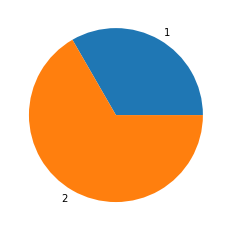

In [11]:
fig1, ax1 = plt.subplots()
ax1.pie([1,2], labels=['1','2'])
plt.show()